# Real World Evidence (#67675) - Project

## Accidental death by fatal drug overdose is a rising trend in the United States. What can we do to help?

The data set used in this project was obtained from https://www.kaggle.com/apryor6/us-opiate-prescriptions

## Data

* `overdoses.csv` - Statistics on opioid related drug overdoses in 2014
* `prescriber-info.csv` - Prescription drug information by doctor in the U.S. 2014
* `opioids.csv` - List of drugs classified as opiates

## Imports

In [211]:
from matplotlib import style as style
import matplotlib.pyplot as plt
style.use('ggplot')
import pandas as pd
import numpy as np
import re
from scipy.stats import spearmanr
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Descriptive Statistics

### State Overdose Statistics

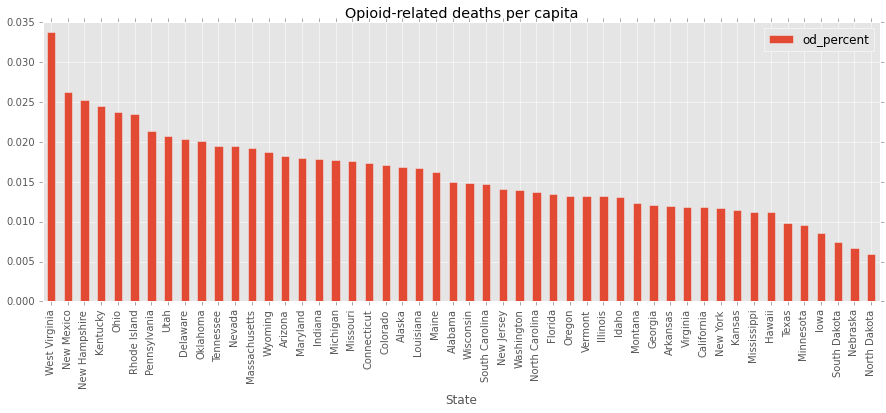

In [71]:
state_ods = pd.read_csv('data/overdoses.csv', thousands=',')
state_ods['od_percent'] = 100 * (state_ods.Deaths / state_ods.Population)
state_ods = state_ods.sort('od_percent', ascending=False)
state_ods.plot(kind='bar', x='State', y='od_percent', title="Opioid-related deaths per capita", figsize=(15,5))
show()

Focusing on the top-10 states, with respect to the percentage of opioid-related overdoses, we see a cluster of east-coast states:

![caption](img/highest_percentage_states.png)

### Prescriber Statistics

In [119]:
prescriber_info = pd.read_csv('data/prescriber-info.csv', thousands=',')
opiad_prescriber_idxs = prescriber_info.apply(lambda r: r['Opioid.Prescriber'] == 1, axis=1)
opiad_prescriber_info = prescriber_info[opiad_prescriber_idxs]
opiad_prescriber_state_grp = opiad_prescriber_info.groupby(['State'])

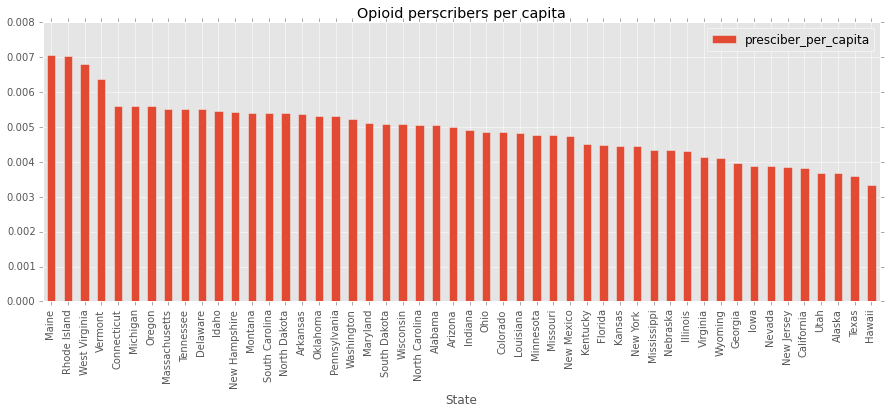

In [203]:
states = [sn for sn, g in opiad_prescriber_state_grp]
opiad_prescribers_state_count = pd.DataFrame({'Abbrev': states, 'num_of_prescribers': opiad_prescriber_state_grp.size()})
opiad_prescribers_state_count.head()
join_ods_prescribers = pd.merge(state_ods, opiad_prescribers_state_count, how='inner', on=['Abbrev'])
join_ods_prescribers['presciber_per_capita'] = 100 * join_ods_prescribers['num_of_prescribers'] / join_ods_prescribers['Population'] 
join_ods_prescribers = join_ods_prescribers.sort('presciber_per_capita', ascending=False)
join_ods_prescribers.plot(kind='bar', x='State', y='presciber_per_capita', title="Opioid perscribers per capita", figsize=(15,5))
show()

#### Correlation between opioid deaths per capita and opioid prescribers per capita 

In [223]:
ods_vs_prescribers = join_ods_prescribers[['od_percent','presciber_per_capita']]
ods_vs_prescribers_mat = ods_vs_prescribers.values.transpose()
rho, pvalue = spearmanr(ods_vs_prescribers_mat[0,:], ods_vs_prescribers_mat[1,:])
print('rho: ' + str(rho))
print('p-value: ' + str(pvalue))

rho: 0.323697478992
p-value: 0.0218413509029


## Classification

### Cleaning the Data

In [200]:
# remove states with a low number of prescriptions
state_sizes = prescriber_info.groupby('State').size()
large_state_ops = state_sizes[state_sizes > 50]
idxs = prescriber_info.apply(lambda r: r.State in large_state_ops.index , axis=1) 
filtered_prescriber_info = prescriber_info[idxs].copy()
# merge similar\small specialties
filtered_prescriber_info = filtered_prescriber_info.replace('.*Surgery.*', 'General Surgery', regex=True)
specialty_group_sizes = filtered_prescriber_info.groupby('Specialty').size()
small_specialty_groups = specialty_group_sizes[specialty_group_sizes < 20]
filtered_prescriber_info.replace(small_specialty_groups.index, 'Other', inplace=True)
filtered_prescriber_info.groupby('Specialty').size()

C:\Anaconda3\lib\site-packages\pandas\core\common.py:516: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x
C:\Anaconda3\lib\site-packages\pandas\core\common.py:523: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


Specialty
Allergy/Immunology                                                 121
Anesthesiology                                                     137
Cardiac Electrophysiology                                           29
Cardiology                                                         688
Certified Clinical Nurse Specialist                                 70
Critical Care (Intensivists)                                        29
Dentist                                                           2790
Dermatology                                                        343
Diagnostic Radiology                                                47
Emergency Medicine                                                1086
Endocrinology                                                      153
Family Practice                                                   2954
Gastroenterology                                                   399
General Practice                                                   

### Opioid vs Non-Opioid Drug Prescriptions 

In [162]:
opioids = pd.read_csv('data/opioids.csv')
op_names = opioids['Drug Name']
cleaned_op_names = op_names.apply(lambda name: re.sub("\ |-",".",str(name)))
prescibers_columns = prescriber_info.columns
common_drugs = set(prescibers_columns).intersection(set(cleaned_op_names))
prescriber_info_only_opioids = prescriber_info[list(common_drugs)]
prescriber_info_no_opioids = prescriber_info[list(set(prescriber_info.columns) - common_drugs)]
print(prescriber_info_only_opioids.shape)
print(prescriber_info_no_opioids.shape)

(25000, 11)
(25000, 245)
